In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.cluster import KMeans
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import numpy as np
import random
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from torchvision.models import resnet18

In [47]:
def seed_torch(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
seed_torch(seed=42)

In [48]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [57]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=128, sparsity_penalty=1e-5):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Sigmoid()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )
        self.sparsity_penalty = sparsity_penalty
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def loss(self, x, output):
        reconstruction_loss = nn.MSELoss()(output, x)
        sparsity_loss = self.sparsity_penalty * torch.mean(torch.abs(self.encoder(x)) - self.sparsity_target)
        return reconstruction_loss + sparsity_loss

In [49]:
seed=42
# 设置数据转换
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(28),
    torchvision.transforms.ToTensor()
])

# 下载并加载MNIST数据集
mnist_train = torchvision.datasets.MNIST(root='./', download=True, transform=transform)
mnist_test = torchvision.datasets.MNIST(root='./', train=False, download=True, transform=transform)

# 设置随机数生成器
generator = torch.Generator().manual_seed(seed)

# 划分训练集和验证集
train_dataset, val_dataset = torch.utils.data.random_split(mnist_train, [50000, 10000], generator=generator)

# 创建训练集和验证集的数据加载器
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [50]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           shuffle=True)
# 定义自编码器模型和优化器
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# 训练自编码器
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data, _ in train_loader:
        data = data.view(-1, 784)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, data)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * data.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/10], Loss: 0.0584
Epoch [2/10], Loss: 0.0301
Epoch [3/10], Loss: 0.0242
Epoch [4/10], Loss: 0.0216
Epoch [5/10], Loss: 0.0201
Epoch [6/10], Loss: 0.0191
Epoch [7/10], Loss: 0.0184
Epoch [8/10], Loss: 0.0178
Epoch [9/10], Loss: 0.0174
Epoch [10/10], Loss: 0.0170


In [51]:
# 提取编码器的输出作为嵌入向量
embeddings = []
model.eval()
with torch.no_grad():
    for data, _ in train_loader:
        data = data.view(-1, 784)
        outputs = model.encoder(data)
        embeddings.extend(outputs.tolist())

embeddings = np.array(embeddings)
print(len(embeddings))
# 选择距离最近的图像作为训练集
known_labels = [1173, 3336, 12529, 12785, 12979, 17351, 27048, 40579, 43128, 46498]
known_images = []
for idx in known_labels:
    known_images.append(embeddings[idx])

known_images = np.array(known_images)

# 使用K-means进行聚类
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(known_images)

# 嵌入空间中的图像数量
num_images = len(embeddings)
num_nearest_images=2000
# 存储每个标签对应的最近图像索引
nearest_indices = []
# 计算每个嵌入向量与标签嵌入向量之间的距离
for i in range(10):
    label_embedding = embeddings[known_labels[i]]
    distances = np.linalg.norm(embeddings - label_embedding, axis=1)
    nearest_indices.extend(np.argsort(distances)[:num_nearest_images])
# 从原始训练集中选择最近图像对应的数据
selected_train_images = [mnist_train[i] for i in nearest_indices]
print(len(selected_train_images))
# 创建训练集的数据加载器
selected_train_loader = torch.utils.data.DataLoader(selected_train_images, batch_size=batch_size, shuffle=True)


50000


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


20000


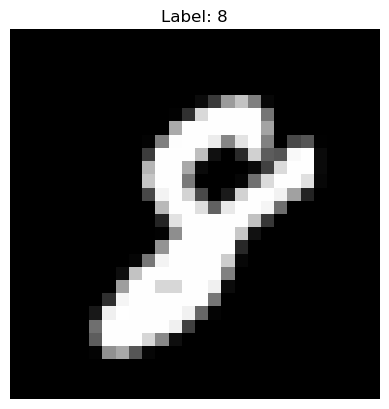

In [52]:
# 选择要展示的图像的索引，随便输，这个我只是验证train_dataset_s用的
index = 4
# 获取图像和标签
image, label = selected_train_images[index]
# 将图像转换为 NumPy 数组
image = image.numpy()
# 显示图像
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [54]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(residual)
        out = self.relu(out)
        return out

# 定义深层卷积神经网络
class ResNet(nn.Module):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 64, blocks=2, stride=1)
        self.layer2 = self._make_layer(64, 128, blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 256, blocks=2, stride=2)
        self.layer4 = self._make_layer(256, 512, blocks=2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [55]:
import torchvision.transforms as transforms
# 在验证集上验证
# 定义训练参数
batch_size = 32
lr = 0.001
num_epochs = 15

# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(28)
])
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 创建模型并将其移到GPU上（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = CNN().to(device)
model=ResNet(num_classes=10).to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_draw=[]
accuracy_draw=[]
# 训练和验证
for epoch in range(num_epochs):
    # 训练模型
    model.train()
    for images, labels in selected_train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    loss_draw.append(loss)
    # 在验证集上进行验证
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    accuracy_draw.append(accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {accuracy:.2f}%")

Epoch [1/15], Validation Accuracy: 94.79%
Epoch [2/15], Validation Accuracy: 97.67%
Epoch [3/15], Validation Accuracy: 97.95%
Epoch [4/15], Validation Accuracy: 97.23%
Epoch [5/15], Validation Accuracy: 97.52%
Epoch [6/15], Validation Accuracy: 97.72%
Epoch [7/15], Validation Accuracy: 96.69%
Epoch [8/15], Validation Accuracy: 98.55%
Epoch [9/15], Validation Accuracy: 98.76%
Epoch [10/15], Validation Accuracy: 97.73%
Epoch [11/15], Validation Accuracy: 98.31%
Epoch [12/15], Validation Accuracy: 98.52%
Epoch [13/15], Validation Accuracy: 98.84%
Epoch [14/15], Validation Accuracy: 98.21%
Epoch [15/15], Validation Accuracy: 99.00%


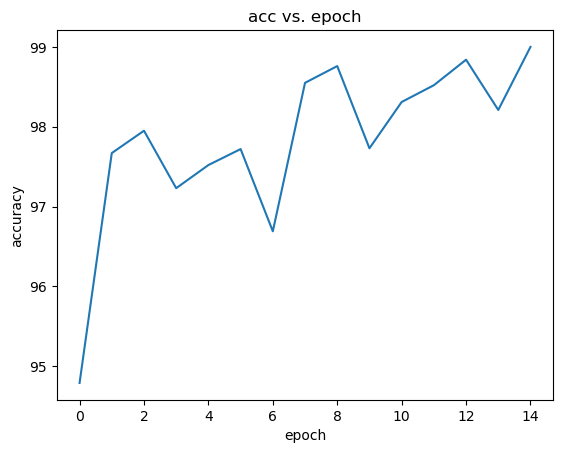

在测试集上的准确率：98.71%


In [56]:
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('acc vs. epoch')
plt.plot(range(num_epochs),accuracy_draw)
plt.show()
# 在测试集上进行测试
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=32, shuffle=True)
model.eval()  # 将模型设置为评估模式
total_correct = 0
total_samples = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # 前向传播
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # 统计预测结果
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

# 计算准确率
accuracy = 100 * total_correct / total_samples
print(f'在测试集上的准确率：{accuracy:.2f}%')